In [28]:
import sys
import os

import matplotlib.pyplot as plt

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [29]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *

In [30]:
def run(dim_parameters, dim_observations, p, beta, num_particles, noise_level=1e-6, print=True):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = LinearForwardModel(
        dim_parameters, dim_observations, p, coef=jnp.pi ** (-2)
    )
    i_array = jnp.linspace(1, dim_parameters, dim_parameters)
    v0 = jnp.apply_along_axis(lambda x: x ** (-beta), 0, i_array)

    y_true = forward_model.evaluate(v0[:, jnp.newaxis])[:, 0]

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    prior_cov = GaussianKernel(dim_parameters, 2)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(0.0, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=1,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)
    if print:
        # Print results
        print(f"\nAlgorithm converged: {results['converged']}")
        print(f"Stopping time: {results['stopping_time']}")
        print(f"Final residual: {results['final_residual']:.6f}")

    return results, v0

In [39]:
# Problem parameters
dim_parameters = 100
dim_observations = 100
p = 2
beta = 3 / 2
num_particles = 100

noise_levels = np.logspace(-2, -6, 5)
print(noise_levels)

[1.e-02 1.e-03 1.e-04 1.e-05 1.e-06]


In [40]:
results_list = []
for noise_level in noise_levels:
    results, v0 = run(dim_parameters, dim_observations, p, beta, num_particles, noise_level)
    results_list.append(results)

0
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.124565
0
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.085361
0
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.084352
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.003394
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.001407


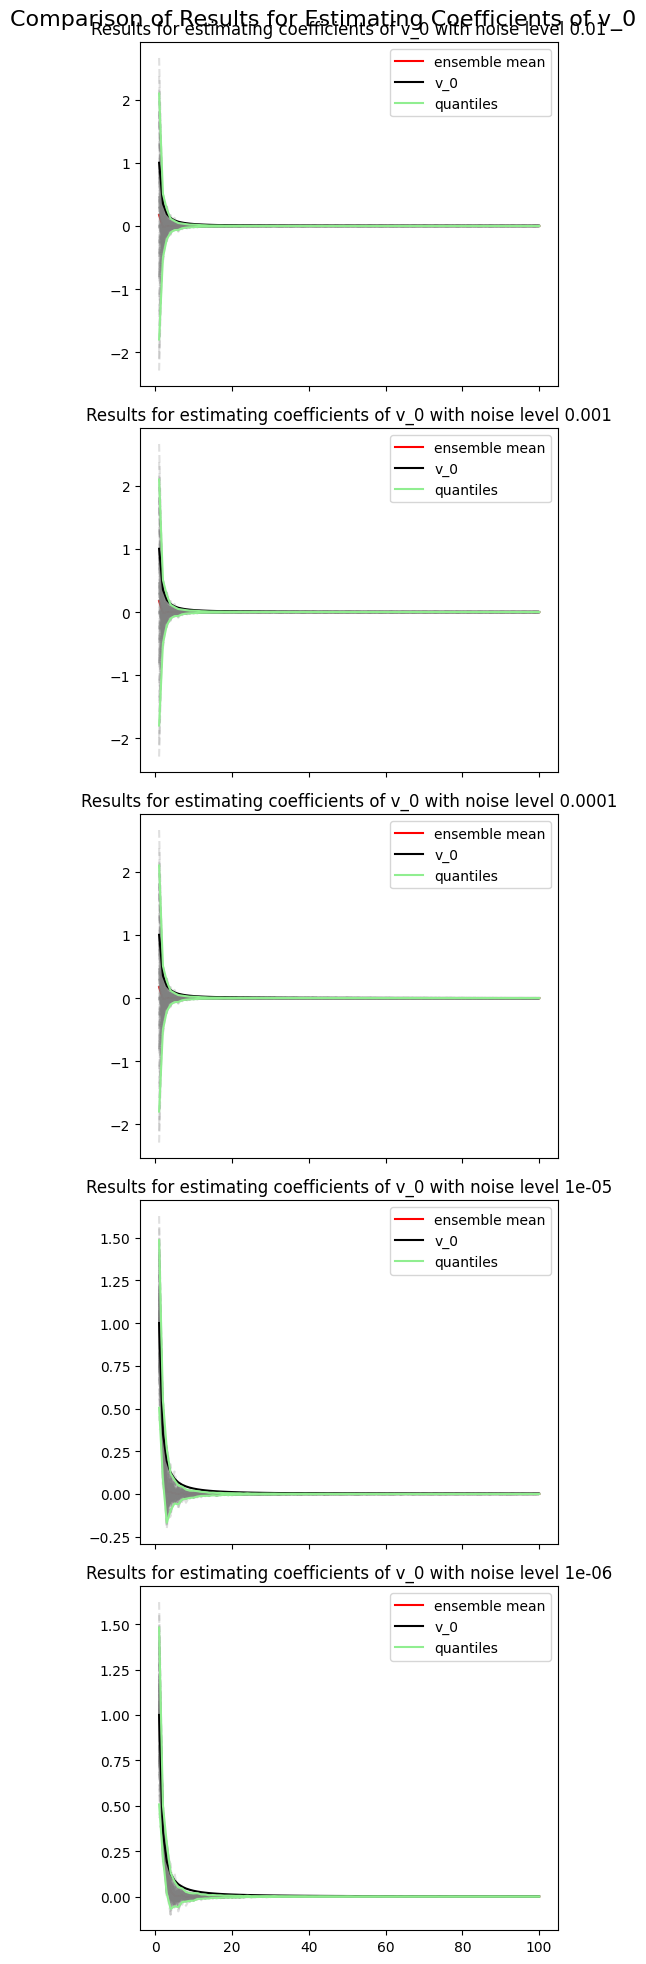

In [44]:
i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

# Create a figure with subplots based on the number of results
num_results = len(results_list)
fig, axes = plt.subplots(num_results, 1, figsize=(5, 4*num_results), sharex=True)

# If there's only one result, axes won't be iterable, so we handle that case
if num_results == 1:
    axes = [axes]

# Loop through the results and create a plot for each one
for i, results in enumerate(results_list):
    hat_coefs_v0_ensemble = results["ensemble_history"][-1]

    # Plot on the current subplot
    ax = axes[i]

    # Plot ensemble mean
    ax.plot(
        i_array, jnp.mean(hat_coefs_v0_ensemble, axis=1),
        color="red", label="ensemble mean"
    )

    # Plot individual ensemble members
    ax.plot(
        i_array, hat_coefs_v0_ensemble,
        color="grey", linestyle="dashed", alpha=0.25
    )

    # Plot true v0
    ax.plot(i_array, v0, color="black", label="v_0")

    # Plot quantiles
    ax.plot(
        i_array,
        jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[0],
        color="lightgreen",
        label="quantiles",
    )
    ax.plot(
        i_array,
        jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[1],
        color="lightgreen"
    )

    # Add title and legend to each subplot
    ax.set_title(f"Results for estimating coefficients of v_0 with noise level {noise_levels[i]}")
    ax.legend()

# Add a common title for the entire figure
fig.suptitle("Comparison of Results for Estimating Coefficients of v_0", fontsize=16)
plt.tight_layout()
plt.show()

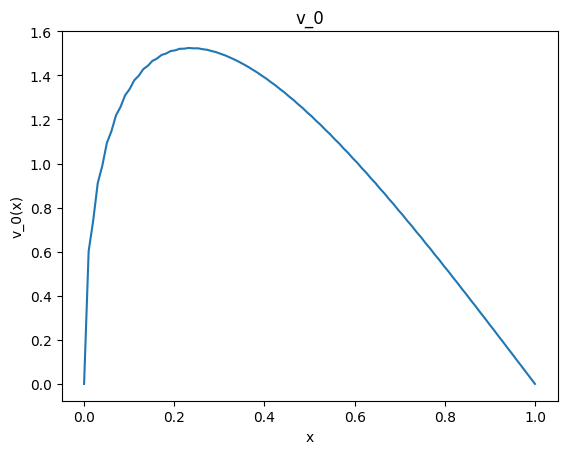

In [33]:
N = 100  # num of grid points
x = jnp.linspace(0, 1, N)
v0_func = get_function(v0, x)
plt.plot(x, v0_func)
plt.xlabel("x")
plt.ylabel("v_0(x)")
plt.title("v_0")
plt.show()

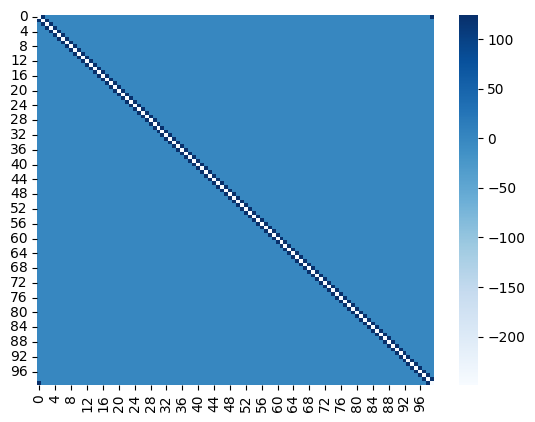

In [34]:
D = N - 1
L = 2 * jnp.pi
h = L / D
x_indices = jnp.arange(D + 1)
x_array = (2 * jnp.pi * x_indices) / (D + 1)
f_array = jnp.exp(0.5 * jnp.sin(x_array))
plot = True
fourier = False
laplace = compute_laplace(D, h)
sns.heatmap(laplace, cmap="Blues")
plt.show()

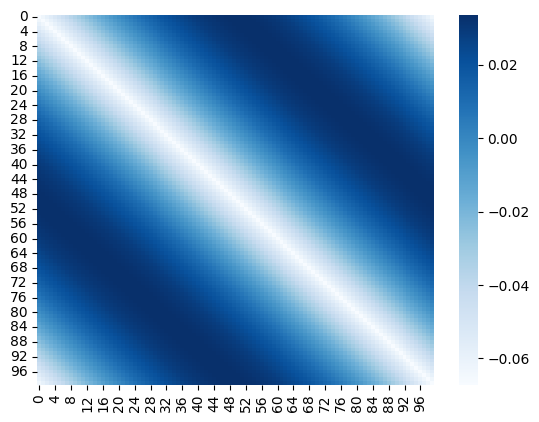

In [35]:
K = jnp.linalg.pinv(laplace)
sns.heatmap(K, cmap="Blues")
plt.show()

In [36]:
v0_func_ensemble = get_function(hat_coefs_v0_ensemble, x)
v0_func_ensemble.shape

(100, 100)

In [37]:
# Create g_array (right-hand side)
g_tilde = jnp.ones(N) + x_array
f0 = solution_map(v0_func, K, g_tilde)

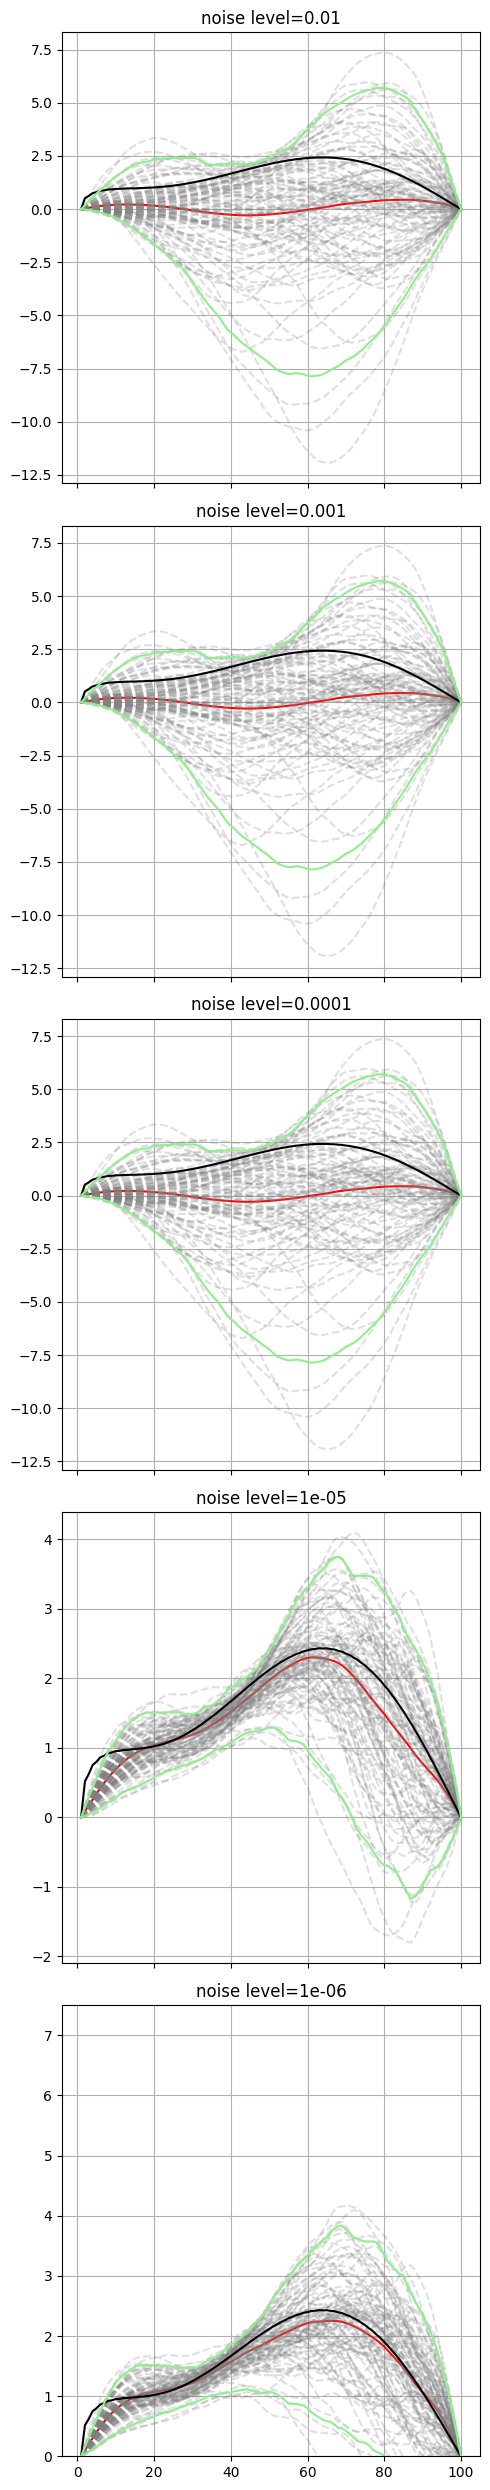

In [64]:
i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

# Create a figure with subplots based on the number of results
num_results = len(results_list)
fig, axes = plt.subplots(num_results, 1, figsize=(5, 5*num_results), sharex=True)

# If there's only one result, axes won't be iterable, so we handle that case
if num_results == 1:
    axes = [axes]

# Loop through the results and create a plot for each one
for i, results in enumerate(results_list):
    hat_coefs_v0_ensemble = results["ensemble_history"][-1]
    v0_func_ensemble = get_function(hat_coefs_v0_ensemble, x)
    f0_ensemble = solution_map(v0_func_ensemble, K, g_tilde)
    # Plot on the current subplot
    ax = axes[i]

    # Plot ensemble mean
    ax.plot(
        i_array, jnp.mean(f0_ensemble, axis=1),
        color="red", label="ensemble mean"
    )

    # Plot individual ensemble members
    ax.plot(
        i_array, f0_ensemble,
        color="grey", linestyle="dashed", alpha=0.25
    )

    # Plot true v0
    ax.plot(i_array, f0, color="black", label="v_0")

    # Plot quantiles
    ax.plot(
        i_array,
        jnp.quantile(f0_ensemble, q, axis=1)[0],
        color="lightgreen",
        label="quantiles",
    )
    ax.plot(
        i_array,
        jnp.quantile(f0_ensemble, q, axis=1)[1],
        color="lightgreen"
    )

    # Add title and legend to each subplot
    ax.set_title(f"noise level={noise_levels[i]}")
    ax.grid(True)

# Add a common title for the entire figure
#fig.suptitle("Comparison of Results for Estimating Coefficients of v_0", fontsize=16)
plt.ylim(0,7.5)
plt.tight_layout()
plt.show()